# Esercizio 5 - Topic Modeling

### Un po' di teoria

In questo esercizio andremo ad utilizzare la libreria gensim per fare il topic modeling, sfruttando l'algoritmo **Latent Dirichlet Allocation**
(LDA). E' un modello *non supervisionato* in quanto non necessita di un dataset annotato per fare il training, il che lo rende un algoritmo 
estremamente versatile e facile da utilizzare.

**Cos'è un topic?**
Un topic è un insieme di keyword dominanti che, dovrebbero, essere rappresentative del topic.

**I fattori chiave per ottenere buoni argomenti di segregazione sono i seguenti:**
- La qualità dell'elaborazione del testo
- La varietà di argomenti di cui parla il testo
- La scelta dell'algoritmo di modellazione degli argomenti
- Il numero di argomenti da fornire all'algoritmo
- I parametri di regolazione dell'algoritmo

**Il funzionamento di questa libreria ruota attorno a 4 concetti:**

- **Document**: del testo - una sequenza di parole
  
- **Corpus**: una collezione di documenti
- **Vector**: convenzione tramite cui rappresentiamo il testo. Ciò ci permette di avere una rappresentazione matematica del testo 
  che abilità una serie di operazioni. In sostanza è una sequenza di numeri che rappresenta un documento.
- **Model**: è un algoritmo che permette di trasformare un vettore da una rappresentazione ad un'altra. E' il modello che viene
  utilizzato per fare il topic modeling.

### Imports

In [14]:
import nltk
import re
import string
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

## Corpus

### Preparazione del dataset

Come dataset abbiamo selezionato da kaggle *"20-Newsgroups"* (https://www.kaggle.com/datasets/crawford/20-newsgroups) che contiene circa 18mila documenti di newsgroup,
che non sono altro che dei post scritti su un determinato argomento, in questo caso abbiamo 20 argomenti diversi.

In [15]:
# Import Dataset
df = pd.read_json('../data/tm_data.json')

In [16]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


### Analiziamo il dataset

In [17]:
#topics
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [18]:
len(df.target_names.unique())

20

In [19]:
df['content'][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [20]:
# Pick the contents and put them into a list
data = []
for content in df['content']:
    data.append(content)

In [21]:
print(data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







### Processing the data

Puliamo il dataset, rimuovendo le porzioni di testo che non ci interessano e che potrebbero compromettere le performance del modello.

In [22]:
#clean the data removing useless stuff
cleaned_data = []

for line in data:
        line = line.lower() #lowercase   
        #line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line) #remove punctuation
        line = re.sub('\S*@\S*\s?', '', line) #remove e-mails
        line = re.sub('\s+', ' ', line) #remove new lines
        line = re.sub("\'", '', line) #remove single quotes
        cleaned_data.append(line.strip())

### Check the data

Prima della pulizia

In [23]:
print(data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







Dopo la pulizia

In [24]:
print(cleaned_data[0])

from: (wheres my thing) subject: what car is this!? nntp-posting-host: rac3.wam.umd.edu organization: university of maryland, college park lines: 15 i was wondering if anyone out there could enlighten me on this car i saw the other day. it was a 2-door sports car, looked to be from the late 60s/ early 70s. it was called a bricklin. the doors were really small. in addition, the front bumper was separate from the rest of the body. this is all i know. if anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. thanks, - il ---- brought to you by your neighborhood lerxst ----


### Tokenization

Tokenizziamo le parole utilizzando la comodissima funzione simple_preprocess di Gensim

In [25]:
#tokenize with Gensim’s simple_preprocess()
def split_sentence(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))    

words1 = list(split_sentence(cleaned_data))

In [26]:
print(words1[0])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


### Prepariamo i dati (bigrammi e trigrammi) per il modello di gensim

Ora entriamo nel vivo dell'esercizio, vediamo il funzionamento del modello *gensim.models.Phrases*:

(Dalla documentazione ufficiale) --> *Automatically detect common phrases – aka multi-word expressions, word n-gram collocations – from a 
stream of sentences.*

E ancora: *Detect phrases based on collocation counts.*


**Analizziamo i parametri:**

- *sentences* = words1 --> Gli passiamo le frasi tokenizzate da analizzare
  
- *min_count* = 5 --> Il numero minimo di occorrenze di una parola per essere considerata (default = 5)
- *threshold* = 100 --> *A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold - (higher means fewer phrases)*
- *connector_words* = ENGLISH_CONNECTOR_WORDS --> Rappresenta una lista di parole che possono essere presenti in una frase senza che lo score della
frase venga incrementato.

Più saranno alti i valori di *min_count* e *threshold*, più sarà difficile che vengano formati dei bigrammi e dei trigrammi.

**Bigrams** --> Coppia di parole che compaiono spesso assieme nel documento

**Trigrams** --> Triple parole che compaiono spesso assieme nel documento

In [27]:
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

bigram = gensim.models.Phrases(words1, min_count=5, threshold=100, 
                              connector_words=ENGLISH_CONNECTOR_WORDS)

trigram = gensim.models.Phrases(bigram[words1], threshold=100, 
                               connector_words=ENGLISH_CONNECTOR_WORDS)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

print(bigram_mod[words1[0]])

#example for data_words1
print(trigram_mod[bigram_mod[words1[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting', 'host', 'rac_wam', 'umd_edu', 'organization', 'university', 'of', 'maryland_college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']
['from', 'wheres', 'my', 'thing', 'subject', '

Riassumiamo all'interno di alcuni metodi i passi principali:

In [28]:
def remove_stopwords(text):
    '''Remove stopwords from text'''
    return [[w for w in simple_preprocess(str(content)) if w not in stopwords] for content in text]

def build_bigrams(text):
    '''construct bigrams from text '''
    return [bigram_mod[content] for content in text]

def build_trigrams(text):
    '''construct trigrams from text'''
    return [trigram_mod[bigram_mod[content]] for content in text]

def lemmatizer(text, pos=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """It assign general context to words in text 
       source: https://spacy.io/api/annotation"""
    output = []
    for s in text:
        content = nlp(" ".join(s)) 
        output.append([tkn.lemma_ for tkn in content if tkn.pos_ in pos])
    return output

In [29]:
# Remove Stop Words
words_cleaned = remove_stopwords(words1)

# Form Bigrams
words_bigrams = build_bigrams(words_cleaned)

#Form Trigrams
words_trigrams = build_trigrams(words_cleaned)

### Diamo un'occhiata ai risultati ottenuti:

In [30]:
print(words_cleaned[0])
len(words_cleaned[0])

['wheres', 'thing', 'subject', 'car', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'maryland', 'college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']


65

In [31]:
print(words_bigrams[0])
len(words_bigrams[0])

['wheres', 'thing', 'subject', 'car', 'nntp_posting', 'host', 'rac_wam', 'umd_edu', 'organization', 'university', 'maryland_college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']


60

In [32]:
print(words_trigrams[0])
len(words_trigrams[0])

['wheres', 'thing', 'subject', 'car', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'maryland_college_park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']


57

### Lemmatization

In [33]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [34]:
# Do lemmatization keeping only noun, adj, vb, adv
lemmatization = lemmatizer(words_bigrams, pos=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(lemmatization[0])
len(lemmatization[0])

['s', 'thing', 'subject', 'car', 'nntp_poste', 'host', 'rac_wam', 'umd_edu', 'organization', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']


51

In [35]:
print(lemmatization[1])
len(lemmatization[1])

['subject', 'clock', 'poll', 'final', 'call', 'summary', 'final', 'call', 'clock', 'report', 'keyword', 'si', 'acceleration', 'clock', 'upgrade', 'innc', 'organization', 'line', 'nntp_poste', 'fair', 'number', 'brave', 'soul', 'upgrade', 'si', 'clock', 'oscillator', 'share', 'experience', 'poll', 'send', 'brief', 'message', 'detail', 'experience', 'procedure', 'top', 'speed', 'attain', 'cpu', 'rate', 'speed', 'add', 'card', 'adapter', 'heat_sink', 'hour', 'usage', 'day', 'floppy_disk', 'functionality', 'floppy', 'especially', 'request', 'summarize', 'next', 'day', 'add', 'network', 'knowledge', 'base', 'do', 'clock', 'upgrade', 'answer', 'poll', 'thank', 'guy_kuo']


68

In [36]:
lemmatization2 = lemmatizer(words_trigrams, pos=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(lemmatization2[0])
len(lemmatization2[0])

['s', 'thing', 'subject', 'car', 'organization', 'university', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']


47

## Vectors

### Trasformiamo i termini in vettori per poterli maneggiare con più semplicità in Gensim

I due elementi principali di cui ha bisogno il modello LDA sono il **corpus** e il **dictionary**, andiamo a costruire il dizionario.

Gensim crea un id unico per ogni parla nel documento. Dopo di crea una lista di coppie **(word_id, word_frequency)**

In [37]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

#Create Dictionary -> assign id to words
common_dictionary = Dictionary(lemmatization)

#Create Corpus
#Term Document Frequency
common_corpus = [common_dictionary.doc2bow(text) for text in lemmatization]

#Gensim creates a unique id for each word in the document. 
#The produced corpus shown above is a mapping of (word_id, word_frequency).
print(common_corpus[0])
len(common_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1)]


45

### Visualizziamo i risultati ottenuti

In [38]:
for i in range(0,5):
    print(common_dictionary[i])

addition
body
bricklin
bring
call


In [39]:
#visualize dictionary
print([[(common_dictionary[i], f) for (i, f) in couple] for couple in common_corpus][0])

[('addition', 1), ('body', 1), ('bricklin', 1), ('bring', 1), ('call', 1), ('car', 5), ('day', 1), ('door', 2), ('early', 1), ('engine', 1), ('enlighten', 1), ('funky', 1), ('history', 1), ('host', 1), ('info', 1), ('know', 1), ('late', 1), ('lerxst', 1), ('line', 1), ('look', 2), ('mail', 1), ('make', 1), ('model', 1), ('name', 1), ('neighborhood', 1), ('nntp_poste', 1), ('organization', 1), ('park', 1), ('production', 1), ('rac_wam', 1), ('really', 1), ('rest', 1), ('s', 1), ('see', 1), ('separate', 1), ('small', 1), ('spec', 1), ('sport', 1), ('subject', 1), ('tellme', 1), ('thank', 1), ('thing', 1), ('umd_edu', 1), ('wonder', 1), ('year', 1)]


In [40]:
print(common_corpus[1])
len(common_corpus[1])

[(4, 2), (6, 2), (18, 1), (25, 1), (26, 1), (38, 1), (40, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 5), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 3), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 3), (90, 1)]


53

In [41]:
# visualize dictionary
print([[(common_dictionary[i], f) for (i, f) in couple] for couple in common_corpus][1])

[('call', 2), ('day', 2), ('line', 1), ('nntp_poste', 1), ('organization', 1), ('subject', 1), ('thank', 1), ('acceleration', 1), ('adapter', 1), ('add', 2), ('answer', 1), ('attain', 1), ('base', 1), ('brave', 1), ('brief', 1), ('card', 1), ('clock', 5), ('cpu', 1), ('detail', 1), ('do', 1), ('especially', 1), ('experience', 2), ('fair', 1), ('final', 2), ('floppy', 1), ('floppy_disk', 1), ('functionality', 1), ('guy_kuo', 1), ('heat_sink', 1), ('hour', 1), ('innc', 1), ('keyword', 1), ('knowledge', 1), ('message', 1), ('network', 1), ('next', 1), ('number', 1), ('oscillator', 1), ('poll', 3), ('procedure', 1), ('rate', 1), ('report', 1), ('request', 1), ('send', 1), ('share', 1), ('si', 2), ('soul', 1), ('speed', 2), ('summarize', 1), ('summary', 1), ('top', 1), ('upgrade', 3), ('usage', 1)]


## Modello

Ora che abbiamo i dati ripuliti e trasformati in vettori possiamo procedere con il training del modello.

Vediamo alcuni hyperparametri che possono essere utilizzati per il training del modello:

- *alpha* and *eta* --> Vanno ad influenzare la sparità dei topic. Di base sono settati a *1.0/num_topics*
  
- *chunchsize* --> Numero di documenti da analizzare per ogni iterazione
- *update_every* --> Determina la frequenza con cui i parametri del modello devono essere aggiornati
- *passes* --> E' il numero totale di passaggi di addestramento

In [42]:
from gensim.models.ldamodel import LdaModel

# Train the model on the corpus.
lda = LdaModel(corpus=common_corpus, id2word=common_dictionary, num_topics=20, per_word_topics=True)

In [43]:
#Each topic is a combination of keywords which contributes a certain weightage to the topic itself.
pprint(lda.print_topics())

[(0,
  '0.016*"gun" + 0.012*"say" + 0.010*"think" + 0.009*"people" + 0.009*"write" '
  '+ 0.007*"line" + 0.007*"know" + 0.007*"make" + 0.007*"subject" + '
  '0.006*"greek"'),
 (1,
  '0.009*"line" + 0.008*"write" + 0.008*"subject" + 0.007*"organization" + '
  '0.004*"article" + 0.004*"say" + 0.004*"planet" + 0.004*"think" + '
  '0.004*"know" + 0.004*"hst"'),
 (2,
  '0.015*"key" + 0.013*"use" + 0.010*"line" + 0.009*"get" + 0.007*"subject" + '
  '0.007*"encryption" + 0.007*"write" + 0.006*"organization" + 0.006*"make" + '
  '0.006*"chip"'),
 (3,
  '0.020*"line" + 0.014*"subject" + 0.013*"window" + 0.012*"image" + '
  '0.012*"use" + 0.011*"color" + 0.010*"key" + 0.010*"motif" + 0.010*"bit" + '
  '0.009*"display"'),
 (4,
  '0.014*"toronto_zoology" + 0.013*"henry_spencer" + 0.012*"loser" + '
  '0.012*"copper" + 0.008*"ax" + 0.007*"applicant" + 0.007*"henry" + '
  '0.007*"scroll" + 0.007*"mans_work" + 0.005*"copy_protection"'),
 (5,
  '0.011*"line" + 0.009*"subject" + 0.009*"use" + 0.008*"org

***Come interpretiamo i precedenti risultati?***

Ci viene ritornata una lista di elementi, il primo elemento corrisponde al numero del topic (da 0 a 19 = 20 topic).

Il secondo elemento invece è una lista di parole con un peso associato, il peso corrisponde a quanto quella parola è presente nel topic, e di 
conseguenza quanta importanza ha nel determinare il topic. Ad esempio se prendiamo l'ultimo topic, il 19, possiamo notare come le prime 3 parole,
che corrispondono a quelle con un peso maggiore e che quindi sono più importanti nel topic, sono *lunch*, *space* e *satellite*. 
Questo ci suggerische che probabilmente quel topic parla di satelliti / spazio / razzi.

### Cerchiamo il topic dalle keywod restituite dal modello usando wordnet

Il seguente metodo ci ritorna le *number* parole più utilizzate per ogni topic

In [44]:
# Inferring the topic from the keywords

def extract_keywords(number):
    '''return a list of the (number) main words for each topic'''
    topic_list=[]
    l = lda.print_topics()
    result = [" ".join(x[1].strip('"') for x in sorted((e.split("*") for e in sl[1].split(" + ")),key=lambda x:float(x[0]),reverse=True)[:number]) for sl in l]
    for i in result:
        topic_list.append(i.split())
    return topic_list

topic_list = extract_keywords(8)
print(topic_list)

[['gun', 'say', 'think', 'people', 'write', 'line', 'know', 'make'], ['line', 'write', 'subject', 'organization', 'article', 'say', 'planet', 'think'], ['key', 'use', 'line', 'get', 'subject', 'encryption', 'write', 'organization'], ['line', 'subject', 'window', 'image', 'use', 'color', 'key', 'motif'], ['toronto_zoology', 'henry_spencer', 'loser', 'copper', 'ax', 'applicant', 'henry', 'scroll'], ['line', 'subject', 'use', 'organization', 'host', 'nntp_poste', 'get', 'write'], ['car', 'line', 'write', 'article', 'subject', 'get', 'go', 'good'], ['say', 'people', 'believe', 'think', 'make', 'christian', 'write', 'know'], ['israeli', 'space', 'subject', 'line', 'write', 'orbit', 'use', 'say'], ['write', 'line', 'article', 'subject', 'point', 'organization', 'nntp_poste', 'host'], ['write', 'line', 'subject', 'article', 'get', 'think', 'go', 'organization'], ['ax', 'rlk', 'mf', '_', 'm', 'pl_pl', 'gy', 'wm'], ['line', 'game', 'team', 'subject', 'year', 'entry', 'organization', 'get'], ['a

Andiamo a cercare i synset dei termini più frequenti per ogni topic e andiamo a ricavare i loro iperonomi e i loro iponimi.

In [45]:
from nltk.corpus import wordnet as wn

synsets = []
counter = 0

for j in topic_list:
    synsets.append([])
    for tp in topic_list[counter]:
        for ss in wn.synsets(str(tp)):
            for hypon in ss.hyponyms(): # search the hyponyms of the synset
                synsets[counter].append(hypon)
            for hyper in ss.hypernyms(): # search the hypernyms of the synset
                synsets[counter].append(hyper)
    counter += 1

In [46]:
for synsList in synsets:
    print(synsList[:10])
    print("...........................")

[Synset('air_gun.n.01'), Synset('antiaircraft.n.01'), Synset('breechloader.n.01'), Synset('cannon.n.02'), Synset('cannon.n.04'), Synset('firearm.n.01'), Synset('gas_gun.n.01'), Synset('minute_gun.n.01'), Synset('quaker_gun.n.01'), Synset('set_gun.n.01')]
...........................
[Synset('chorus.n.04'), Synset('diagonal.n.03'), Synset('linemen.n.01'), Synset('lineup.n.02'), Synset('rank.n.01'), Synset('rivet_line.n.01'), Synset('row.n.01'), Synset('formation.n.01'), Synset('ascender.n.03'), Synset('bar_line.n.01')]
...........................
[Synset('ignition_key.n.01'), Synset('latchkey.n.01'), Synset('passkey.n.01'), Synset('device.n.01'), Synset('explanation.n.02'), Synset('pitch.n.01'), Synset('major_key.n.01'), Synset('minor_key.n.01'), Synset('tonic_key.n.01'), Synset('musical_notation.n.01')]
...........................
[Synset('chorus.n.04'), Synset('diagonal.n.03'), Synset('linemen.n.01'), Synset('lineup.n.02'), Synset('rank.n.01'), Synset('rivet_line.n.01'), Synset('row.n.

Andiamo a cercare tra gli iperonimi e gli iponimi delle parole più frequenti per ogni topic il synset più frequente per ogni topic, che
potrebbe corrispondere al topic di riferimento.

In [47]:
from collections import Counter

# Try to infer the topic from keywords
def obtain_synset(synsets_list):
    max_value = 0
    counter = 0

    for hyp in synsets_list:
        counter += 1
        print("Topic " + str(counter))
        dic = Counter(hyp)
        for (key,value) in zip(dic.keys(),dic.values()):
            if value > max_value:
                max_value = value
        for (key,value) in zip(dic.keys(),dic.values()):
            if value == max_value:
                print(key,value)
        max_value = 0
        print()
                
obtain_synset(synsets)

Topic 1
Synset('make.v.03') 5

Topic 2
Synset('think.v.03') 3

Topic 3
Synset('activity.n.01') 3
Synset('communicate.v.02') 3

Topic 4
Synset('person.n.01') 3
Synset('appearance.n.01') 3

Topic 5
Synset('old_maid.n.04') 1
Synset('contestant.n.01') 1
Synset('bankrupt.n.01') 1
Synset('flash_in_the_pan.n.01') 1
Synset('flop.n.02') 1
Synset('underdog.n.01') 1
Synset('unfortunate.n.01') 1
Synset('gambler.n.01') 1
Synset('blister_copper.n.01') 1
Synset('conductor.n.02') 1
Synset('metallic_element.n.01') 1
Synset('penny.n.02') 1
Synset('policeman.n.01') 1
Synset('reddish_brown.n.01') 1
Synset('american_copper.n.01') 1
Synset('lycaenid.n.01') 1
Synset('coat.v.01') 1
Synset('broadax.n.01') 1
Synset('common_ax.n.01') 1
Synset('double-bitted_ax.n.01') 1
Synset('fireman's_ax.n.01') 1
Synset('hatchet.n.02') 1
Synset('ice_ax.n.01') 1
Synset('poleax.n.01') 1
Synset('edge_tool.n.01') 1
Synset('chop.v.05') 1
Synset('end.v.02') 1
Synset('aspirant.n.01') 1
Synset('bidder.n.01') 1
Synset('claimant.n.01') 

### Valutiamo le performance del modello

- **Perplexity:** In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. 
  A low perplexity indicates the probability distribution is good at predicting the sample.

- **Coherence Score:** The coherence score is for assessing the quality of the learned topics. 
  For one topic, the words 𝑖,𝑗 being scored in ∑𝑖<𝑗Score(𝑤𝑖,𝑤𝑗) have the highest probability of occurring for that topic. 
  You need to specify how many words in the topic to consider for the overall score.


In [48]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda.log_perplexity(common_corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=lemmatization, dictionary=common_dictionary,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.010859538867328

Coherence Score:  0.4910247892682995


### Organizziamo in una tabella i risultati ottenuti

In [57]:
# Show dominant topic and its percentage of contribution in each document

def format_topics_sentences(ldamodel=None, corpus=common_corpus, texts=data):
    '''source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/'''
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=lemmatization2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/var/folders/1h/nl4lppwj1hgdkrq7c63vgdpr0000gn/T/ipykernel_17759/2912771358.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/1h/nl4lppwj1hgdkrq7c63vgdpr0000gn/T/ipykernel_17759/2912771358.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6,0.8301,"car, line, write, article, subject, get, go, good, year, well","[s, thing, subject, car, organization, university, line, wonder, enlighten, car, see, day, door,..."
1,1,16,0.7779,"use, file, line, _, system, subject, program, write, software, also","[subject, clock, poll, final, call, summary, final, call, clock, report, keyword, si, accelerati..."
2,2,14,0.5083,"use, line, drive, problem, get, subject, card, work, organization, driver","[subject, question, organization, purdue_university_engineere, computer, network, distribution_u..."
3,3,12,0.4378,"line, game, team, subject, year, entry, organization, get, nntp_poste, host","[system, division, line, distribution_world_nntp_poste, host, newsreader_tin_version_pl, write, ..."
4,4,16,0.9056,"use, file, line, _, system, subject, program, write, software, also","[subject, question, organization, cambridge, line, article, rat, write, clear, caution, warning,..."
5,5,0,0.7572,"gun, say, think, people, write, line, know, make, subject, greek","[foxvog_dougla, subject, reword, idea, organization, vtt, line, article, tavare, write, article,..."
6,6,17,0.2387,"people, government, write, right, make, line, subject, go, say, article","[man, subject, brain, tumor, treatment, line, people, respond, request, info, treatment, astrocy..."
7,7,14,0.5751,"use, line, drive, problem, get, subject, card, work, organization, driver","[grubb, subject, ide_vs_scsi, organization, university, line, distribution_world_nntp_poste, hos..."
8,8,16,0.5618,"use, file, line, _, system, subject, program, write, software, also","[subject, win, icon, help, please, organization, line, win, download, several, icon, bmp, figure..."
9,9,5,0.7356,"line, subject, use, organization, host, nntp_poste, get, write, make, window","[subject, sigma_design, double, article, pellettiere, write, look, information, sigma_design, do..."


In [59]:
d = Counter(df_dominant_topic['Dominant_Topic'])
D = dict(sorted(d.items()))

**Mostriamo quante volte le parole dei *Dominant Topic* compaiono in ogni topic**

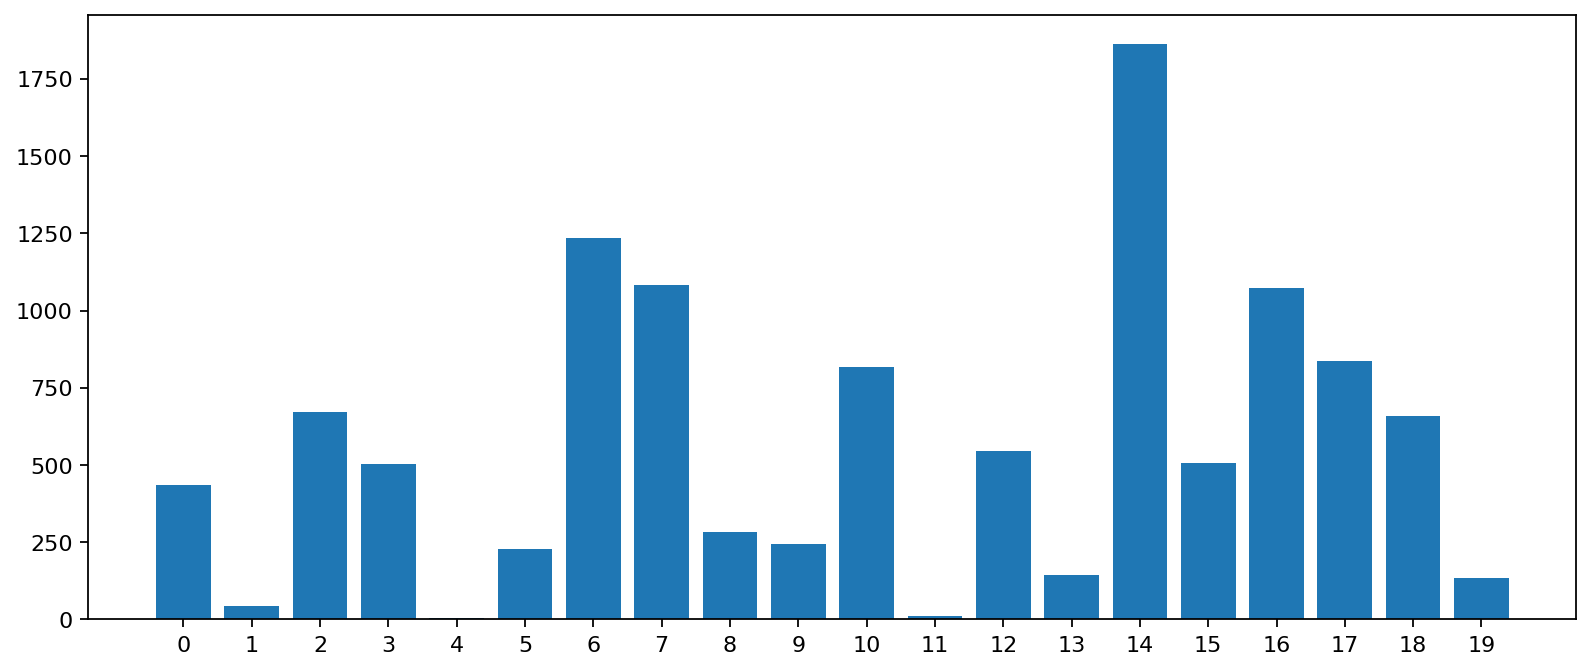

In [54]:
# Distribution of topics in the documents
plt.figure(figsize=(12,5), dpi=160)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), [i for i in range(20)])

plt.show()

### Visualizziamo per ogni topic la frase (insieme di parole dopo la tokenizzazione) più rappresentative del topic 

In [55]:
# Represent the most representative sentence for each topic
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for (i, grp) in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9900,"gun, say, think, people, write, line, know, make, subject, greek","[hossien_amehdi, subject, tbilisi, src, honeywell, com, organization, honeywell, system, researc..."
1,1,0.9455,"line, write, subject, organization, article, say, planet, think, know, hst","[subject, nhl_summary_parse, result, game, play, line, buffalo, first, period, hawgood, dineen, ..."
2,2,0.9971,"key, use, line, get, subject, encryption, write, organization, make, chip","[security, line, article, privacy, security, proposal, clinton_administration, today, make, majo..."
3,3,0.9915,"line, subject, window, image, use, color, key, motif, bit, display","[subject, draw, line, inverse, mit, medium, laboratory, line, m, try, write, code, let, draw, li..."
4,4,0.4802,"toronto_zoology, henry_spencer, loser, copper, ax, applicant, henry, scroll, mans_work, copy_pro...","[steven_smith, subject, holocaust_memorial_museum_costly, dangerous_mistake, reply, message, uni..."
5,5,0.9939,"line, subject, use, organization, host, nntp_poste, get, write, make, window","[subject, nuclear_sites_cooling_tower, organization, line_communication, line, write, excerpt, n..."
6,6,0.9944,"car, line, write, article, subject, get, go, good, year, well","[subject, sc, organization, line, reply, previous, article, say, write, article, write, article,..."
7,7,0.9950,"say, people, believe, think, make, christian, write, know, claim, question","[carol_alvin, subject, arrogance, christian, line, virgilio_dean, velasco_jr_write, article, wri..."
8,8,0.9856,"israeli, space, subject, line, write, orbit, use, say, organization, article","[subject, organization, lines_nntp_poste, host, article, write, echo, balloon, inflate, substanc..."
9,9,0.9926,"write, line, article, subject, point, organization, nntp_poste, host, think, know","[andreas_arff, subject, host, pc, ostfold, college, article, write, michael_nerone, subject, new..."


### Wordcloud dei risultati ottenuti

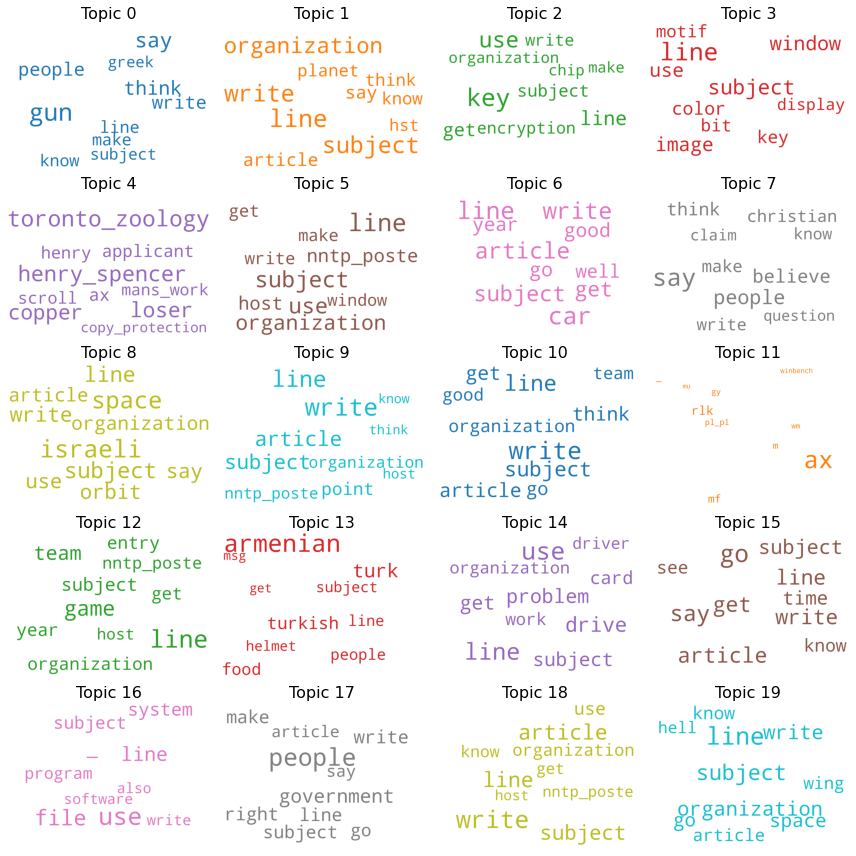

In [53]:
# Wordcloud of Top N words in each topic
# word cloud with the size of the words proportional to the weight
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[-10+i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(5, 4, figsize=(12,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()